# Transfer öğrenme 

---



In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)



Mounted at /content/drive/


In [ ]:
!mkdir -p drive
!google-drive-ocamlfuse drive
!ls

shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
mkdir: cannot create directory ‘drive’: Transport endpoint is not connected
shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
/bin/bash: google-drive-ocamlfuse: command not found
shell-init: error retrieving current directory: getcwd: cannot access parent directories: Transport endpoint is not connected
ls: cannot open directory '.': Transport endpoint is not connected


In [ ]:
import os
os.chdir("/content/drive/My Drive/bitirmepy")
!pwd

/content/drive/My Drive/bitirmepy


## Data preprocessing

In [ ]:
'''
_URL = 'tf'
path_to_zip = tf.keras.utils.get_file('tf.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(tf), 'tf')
'''
train_dir = 'tf/train/'
validation_dir = 'tf/validation/'

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)

Found 1117 files belonging to 2 classes.


In [ ]:
validation_dataset = image_dataset_from_directory(validation_dir,
                                                  shuffle=True,
                                                  batch_size=BATCH_SIZE,
                                                  image_size=IMG_SIZE)

Found 503 files belonging to 2 classes.


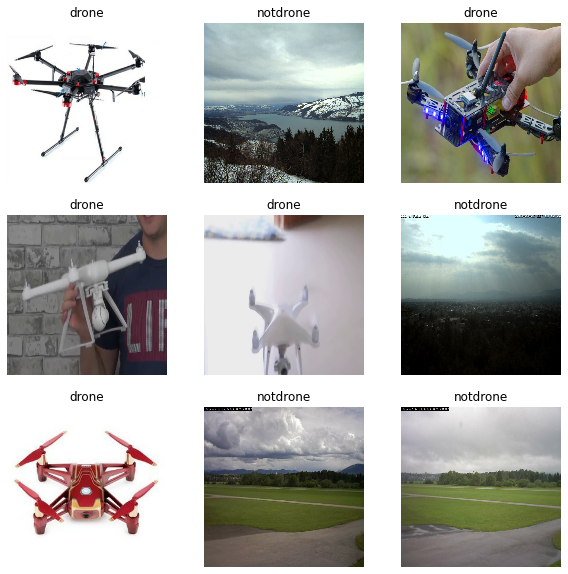

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

test kümesi %20

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [ ]:
print('validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 13
Number of test batches: 3


### Configure the dataset for performance

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### Use data augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

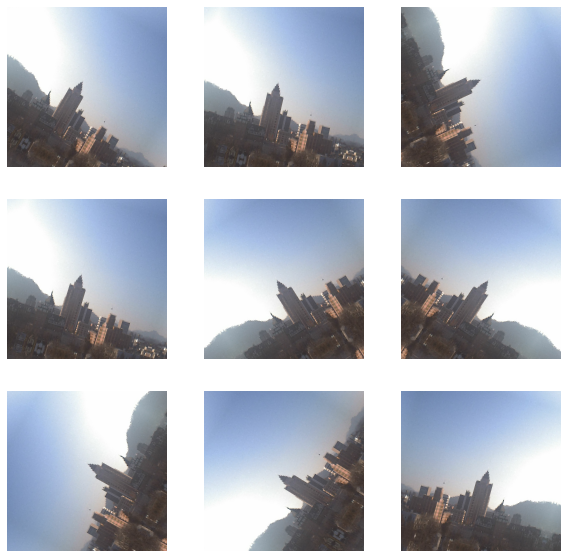

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

## Base Model

uygun [-1, 1] piksel değerleri için ön işleme

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

IMAGENET modeli yükle, Son katmanları içermiyor.

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


özellik çıkarıcı çıktısı

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


Evrişim Ağı Modelini dondur

In [ ]:
base_model.trainable = False

In [ ]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

Özellik çıkarıcı katmandan gelen 5x5 in ortalaması ile tek bir 1280 elemanlı vektör

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Görüntü başına tek tahmin için Dense katmanı. Sonuç 1 veya 0

In [ ]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


Keras API ile, tüm katmanları bağlayarak model oluştur.

In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)  
model = tf.keras.Model(inputs, outputs)

iki sınıf olduğundan ve doğrusal çıktı sağladığından from_logits = true

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [ ]:
len(model.trainable_variables)

2

In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

13/13 [==============================] - 86s 2s/step - loss: 0.5817 - accuracy: 0.6486


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.58
initial accuracy: 0.65


In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
35/35 [==============================] - 142s 4s/step - loss: 0.5695 - accuracy: 0.6795 - val_loss: 0.4259 - val_accuracy: 0.8182
Epoch 2/10
35/35 [==============================] - 8s 201ms/step - loss: 0.4206 - accuracy: 0.7851 - val_loss: 0.3239 - val_accuracy: 0.8821
Epoch 3/10
35/35 [==============================] - 8s 207ms/step - loss: 0.3162 - accuracy: 0.8702 - val_loss: 0.2361 - val_accuracy: 0.9459
Epoch 4/10
35/35 [==============================] - 8s 199ms/step - loss: 0.2486 - accuracy: 0.9185 - val_loss: 0.1912 - val_accuracy: 0.9681
Epoch 5/10
35/35 [==============================] - 8s 203ms/step - loss: 0.2111 - accuracy: 0.9320 - val_loss: 0.1596 - val_accuracy: 0.9803
Epoch 6/10
35/35 [==============================] - 8s 199ms/step - loss: 0.1599 - accuracy: 0.9660 - val_loss: 0.1378 - val_accuracy: 0.9803
Epoch 7/10
35/35 [==============================] - 8s 198ms/step - loss: 0.1404 - accuracy: 0.9731 - val_loss: 0.1215 - val_accuracy: 0.9828
Epoch 8

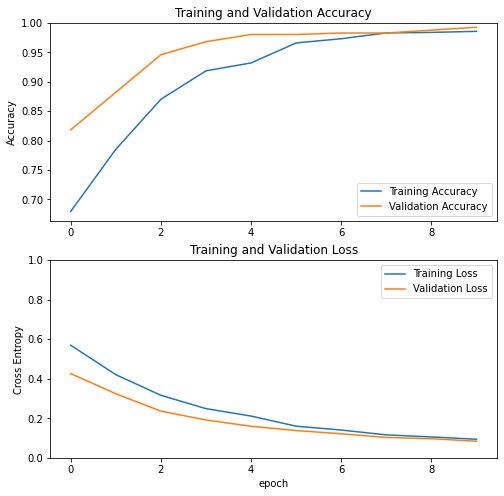

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Evaluation and prediction

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

3/3 [==============================] - 1s 115ms/step - loss: 0.0692 - accuracy: 1.0000
Test accuracy : 1.0


Predictions:
 [0 1 1 0 1 0 1 1 0 0 0 0 1 1 0 0 0 0 0 1 1 1 0 1 1 0 0 0 1 0 0 0]
Labels:
 [0 1 1 0 1 0 1 1 0 0 0 0 1 1 0 0 0 0 0 0 1 1 0 1 1 0 0 0 1 0 0 0]


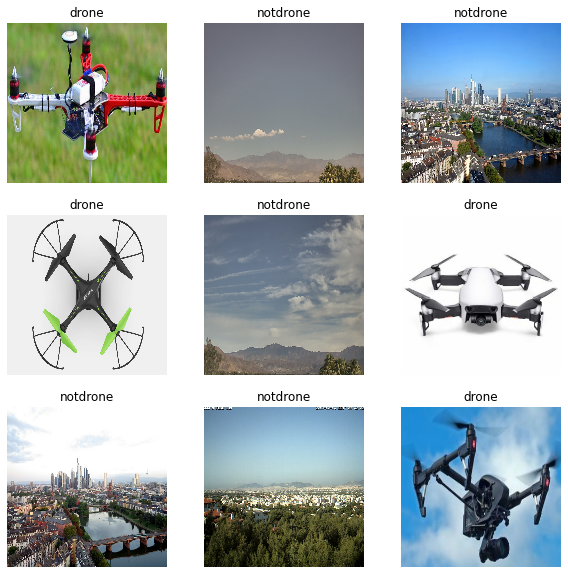

In [ ]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

## Save Model

In [ ]:
model.save("model/keras_model.h5")


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
